In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('dark_background')

In [23]:
from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/PORTOFOLIO/ojek_online_pricing_10000.csv')

print('\n')
print(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


      distance_km  estimated_duration_min  pickup_hour  pickup_day  \
0       11.548934               37.502640           21           3   
1       28.546072               90.371845            1           2   
2       22.093821               63.018379            3           6   
3       18.160425               67.457505           12           6   
4        5.102550               17.620372           12           2   
...           ...                     ...          ...         ...   
9995    25.800852              109.758816           12           0   
9996    26.976511               69.967031            2           4   
9997    28.427883               88.336718           14           0   
9998    12.225896               41.404708           14           4   
9999     6.905642               19.643303            2           0   

      traffic_level  weather

Descriptive Statistics
        distance_km  estimated_duration_min   pickup_hour    pickup_day  \
count  10000.000000            10000.000000  10000.000000  10000.000000   
mean      15.077707               52.883414     11.613100      3.023500   
std        8.485089               31.391550      6.886519      2.007025   
min        0.500343                1.289857      0.000000      0.000000   
25%        7.766702               26.313551      6.000000      1.000000   
50%       15.029594               50.970180     12.000000      3.000000   
75%       22.330187               76.399708     18.000000      5.000000   
max       29.991671              134.019401     23.000000      6.000000   

       traffic_level  weather_condition  vehicle_type  service_type  \
count   10000.000000       10000.000000  10000.000000  10000.000000   
mean        0.748000           0.348100      0.492800      0.403500   
std         0.727289           0.571978      0.659084      0.661915   
min         0.000

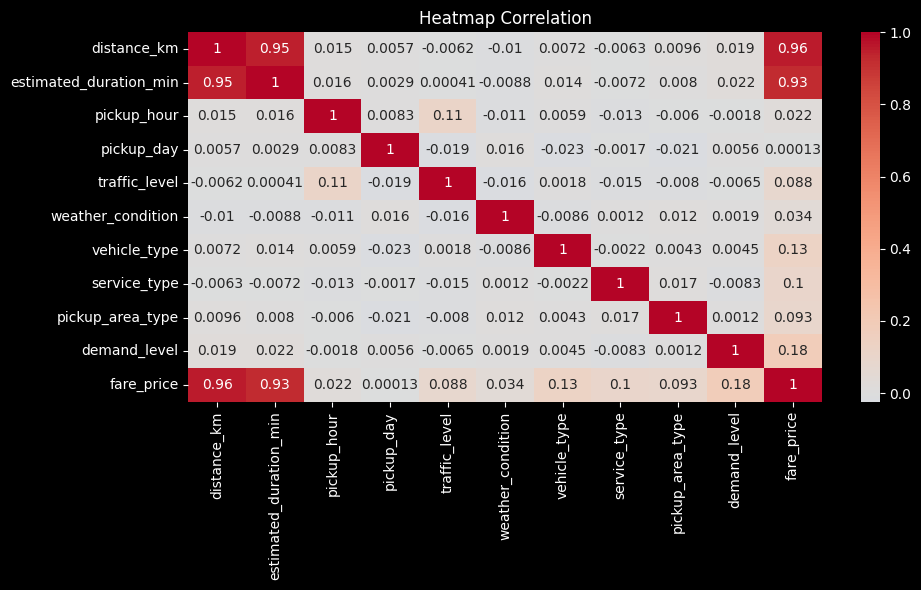

In [24]:
# Descriptive Statistics
print('Descriptive Statistics')
print(df.describe())
print('\n')

# Correlation between Features
print('Correlation towards fare price')
correlation = df.corr()['fare_price'].sort_values(ascending=False)
print(correlation)
print('\n')

# Correlation Visualization
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot= True, cmap= 'coolwarm', center=0)
plt.title('Heatmap Correlation')
plt.tight_layout()
plt.show()

In [25]:
# SEEING DATA TRAINING

X = df.iloc[:,:-1]
y = df['fare_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Data Training (rows, columns): {X_train.shape}')
print(f'Data Test (rows, columns): {X_test.shape}')
print('\n')

df_train = X_train.copy()
df_train['fare_price'] = y_train
df_train = df_train.reset_index(drop=True)
print(df_train)


Data Training (rows, columns): (8000, 10)
Data Test (rows, columns): (2000, 10)


      distance_km  estimated_duration_min  pickup_hour  pickup_day  \
0       23.239028               64.924013           18           2   
1        7.487681               22.518406           16           1   
2       11.728387               37.218997            4           6   
3        6.576651               27.898343            1           1   
4        4.344381               13.889390           13           1   
...           ...                     ...          ...         ...   
7995    20.475166               71.919091            8           1   
7996    21.173848               56.044834            9           0   
7997     4.613782               12.914877            7           2   
7998    23.378065              102.841857           21           1   
7999     9.961009               34.712576            3           3   

      traffic_level  weather_condition  vehicle_type  service_type  \
0      

In [26]:
# HYPERPARAMETER TUNING USING RandomSearchCV

parameter_randomsearch = {
    'n_estimators' : [200,300,400,600],
    'max_depth' : [3,4,5,6],
    'learning_rate' : [0.01, 0.05, 0.1],
    'sub_sample' : [0.6, 0.8, 1],
    'col_sample_bytree' : [0.6, 0.8, 1]
}


random_search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state = 42),
    parameter_randomsearch,
    n_iter = 30,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f'Best Parameters:{random_search.best_params_}')
print(f'RMSE: Rp{round((-random_search.best_score_)**0.5)}')

Best Parameters:{'sub_sample': 1, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1, 'col_sample_bytree': 1}
RMSE: Rp3185


In [27]:
# DATA MODELING
xgboost_model = xgb.XGBRegressor(
    n_estimators = 400,
    max_depth = 3,
    sub_sample = 1,
    col_sample_bytree = 1,
    learning_rate = 0.1,
    random_state = 42
)

xgboost_model.fit(X_train, y_train)


# PREDICTION TOWARDS DATA TESTING USING MODEL
y_pred = xgboost_model.predict(X_test)

test_data = X_test.copy()
test_data['fare_price'] = y_test.values
test_data['fare_price_pred'] = y_pred
test_data['difference'] = np.abs(test_data['fare_price_pred']-test_data['fare_price'])

test_data.reset_index(drop=True)

,distance_km,estimated_duration_min,pickup_hour,pickup_day,traffic_level,weather_condition,vehicle_type,service_type,pickup_area_type,demand_level,fare_price,fare_price_pred,difference
0,10.455573,28.165058,17,3,2,0,1,0,2,0,71519.0,69323.898438,2195.101562
1,23.377406,95.350812,11,5,1,1,1,1,2,2,151776.0,150708.343750,1067.656250
2,18.904927,55.158415,6,0,1,0,0,0,1,1,98286.0,97428.343750,857.656250
3,1.549912,6.372945,13,2,0,0,1,0,1,1,26796.0,30005.890625,3209.890625
4,17.524954,76.826263,18,6,1,1,0,0,1,1,104551.0,101420.023438,3130.976562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,25.768874,100.918727,4,2,0,1,1,0,0,0,130411.0,125715.148438,4695.851562
1996,25.495254,91.883580,3,5,1,0,0,0,1,0,119429.0,121073.890625,1644.890625
1997,9.224709,31.608586,14,1,1,0,0,0,2,2,75682.0,71883.640625,3798.359375
1998,5.707577,17.859209,12,3,0,0,0,0,1,1,40423.0,38650.242188,1772.757812


In [28]:
# METRICS EVALUATION

mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)


print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: Rp{rmse:.2f}')
print(f'R2: {r2:.2f}')

MAE: 2605.58
MSE: 10556843.05
RMSE: Rp3249.13
R2: 0.99


In [30]:
# PREDICTING RESULT OF NEW DATA USING MODEL

distance_km = int(input('Distance (km): '))
estimated_duration = int(input('Duration (mins): '))
pick_up_hour =  int(input('Pick-Up Hour : '))
pick_up_day =  int(input('Day : '))
traffic_level =  int(input('Traffic : '))
weather_condition =  int(input('Weather : '))
vehicle_type =  int(input('Vehicle : '))
service_type =  int(input('Service : '))
pickup_area_type =  int(input('Pick-Up Area Type: '))
demand_level	=  int(input('Demand Level: '))


new_data = {
    'distance_km' : [distance_km],
    'estimated_duration_min' : [estimated_duration],
    'pickup_hour' : [pick_up_hour],
    'pickup_day' : [pick_up_day],
    'traffic_level' : [traffic_level],
    'weather_condition' : [weather_condition],
    'vehicle_type' : [vehicle_type],
    'service_type' : [service_type],
    'pickup_area_type' : [pickup_area_type],
    'demand_level' : [demand_level]
}

new_data_df = pd.DataFrame(new_data)


new_data_model = xgboost_model.predict(new_data_df)[0]
print(f'Predicted Fare Price: Rp{new_data_model:.2f}')

Distance (km): 10
Duration (mins): 100
Pick-Up Hour : 7
Day : 0
Traffic : 2
Weather : 2
Vehicle : 2
Service : 2
Pick-Up Area Type: 0
Demand Level: 2
Predicted Fare Price: Rp114412.69
